# Neural Networks

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyrsm as rsm
import statsmodels.formula.api as smf
from sklearn import preprocessing
from statsmodels.genmod.families import Binomial
from statsmodels.genmod.families.links import logit
import os
import seaborn as sns
from sklearn.neural_network import MLPClassifier
from sklearn.utils import resample
from pyrsm import profit_max, confusion, profit_plot, gains_plot, lift_plot, ROME_plot
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

In [4]:
mpl.rcParams["figure.dpi"] = 150

In [54]:
intuit75k = pd.read_pickle("data/intuit75k.pkl")
intuit75k["res1_yes"] = (intuit75k["res1"] == "Yes").astype(int)

In [56]:
intuit75k.describe()

,id,zip_bins,bizflag,numords,dollars,last,sincepurch,version1,owntaxprod,upgraded,training,res1_yes
count,75000.000000,75000.000000,75000.000000,75000.000000,75000.000000,75000.000000,75000.000000,75000.00000,75000.000000,75000.000000,75000.000000,75000.000000
mean,37500.500000,10.498333,0.245080,2.076280,93.087133,15.838427,15.657173,0.21400,0.028693,0.208387,0.700000,0.048013
std,21650.779432,5.765751,0.430137,1.241355,81.205900,9.539057,10.026312,0.41013,0.166944,0.406157,0.458261,0.213796
min,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,18750.750000,5.000000,0.000000,1.000000,37.000000,8.000000,7.000000,0.00000,0.000000,0.000000,0.000000,0.000000
50%,37500.500000,10.000000,0.000000,2.000000,71.000000,15.000000,14.000000,0.00000,0.000000,0.000000,1.000000,0.000000
75%,56250.250000,15.000000,0.000000,3.000000,124.500000,24.000000,24.000000,0.00000,0.000000,0.000000,1.000000,0.000000
max,75000.000000,20.000000,1.000000,5.000000,1149.000000,36.000000,36.000000,1.00000,1.000000,1.000000,1.000000,1.000000


### Tranformation of data and setting up the Neural Network

- For optimum performance, the data that we input into neural networks should be standardized. Hence we standardize all the numeric inputs before feeding them into the model.
- Categorical variables with two classes need not be transformed. However, categorical variables with more than two classes need to be encoded using one hot encoding before feeding them into the model.
- The beauty of Neural Networks is that they reduce the need for feature engineering to a large extent. It always advisable to pick features for your model based on domain knowledge. However, even if this isn't feasible, a neural network is efficient is picking up inherent patterns in the data and hence will adjust weights for a feature based on its impact.
- We have decided to use 'zip_bins' as a categorical variable instead of 'zip' in our model.
- 'id' has also been dropped as it does not  contribute to the model.

In [7]:
# Standardization

scaler = preprocessing.StandardScaler()
sf = scaler.fit(intuit75k.query('training==1')[['numords','dollars','last','sincepurch']])
intuit75k[['numords','dollars','last','sincepurch']] = sf.transform(intuit75k[['numords','dollars','last','sincepurch']])

In [8]:
# One hot encoding

intuit75k = intuit75k.join(pd.get_dummies(intuit75k.sex), how='inner')
intuit75k = intuit75k.join(pd.get_dummies(intuit75k.zip_bins), how='inner')

In [9]:
intuit_train = intuit75k.query('training == 1').reset_index()
intuit_val = intuit75k.query('training == 0').reset_index()

In [10]:
intuit_train.dtypes

index            int64
id               int32
zip             object
zip_bins         int32
sex           category
bizflag          int32
numords        float64
dollars        float64
last           float64
sincepurch     float64
version1         int32
owntaxprod       int32
upgraded         int32
res1          category
training         int32
res1_yes         int64
Female           uint8
Male             uint8
Unknown          uint8
1                uint8
2                uint8
3                uint8
4                uint8
5                uint8
6                uint8
7                uint8
8                uint8
9                uint8
10               uint8
11               uint8
12               uint8
13               uint8
14               uint8
15               uint8
16               uint8
17               uint8
18               uint8
19               uint8
20               uint8
dtype: object

In [11]:
X_train = intuit_train.drop(columns=['id','zip', 'zip_bins','res1','res1_yes','training','sex','index'])
y_train = intuit_train[['res1_yes']]
X_test = intuit_val.drop(columns=['id','zip', 'zip_bins','res1','res1_yes','training','sex','index'])
y_test = intuit_val[['res1_yes']]

### Neural Network Model 1

- For the first neural network model, we chose 3 hidden layers with 100 nodes each. We chose 'tanh' as our activation function and adam as our solver.

In [12]:
clf_1 = MLPClassifier(random_state=123, activation='tanh', solver='adam', max_iter=3000, hidden_layer_sizes = (100,100,100)).fit(X_train, y_train.values.ravel())

In [13]:
# Prediction probabilities on the test set
pred = clf_1.predict_proba(X_test)
probs = pd.Series([p[1] for p in pred])

# Prediction probabilities on the train set
pred_train = clf_1.predict_proba(X_train)
probs_train = pd.Series([p[1] for p in pred_train])

In [14]:
fpr, tpr, thresholds = metrics.roc_curve(y_test.res1_yes, pred[:,1])
print(f'Test data auc is {metrics.auc(fpr,tpr)}')

Test data auc is 0.6163136171426749


In [15]:
fpr, tpr, thresholds = metrics.roc_curve(y_train.res1_yes, pred_train[:,1])
print(f'Train data auc is {metrics.auc(fpr,tpr)}')

Train data auc is 0.9997984308009585


In [16]:
breakeven = 1.41/60

In [17]:
# Profit calculation on test data

pred_prof = pd.Series((probs/2)) 
pred_prof.name = 'predictions_model_1_test'

pred_prof_train = pd.Series((probs_train/2))
pred_prof_train.name = 'predictions_model_1_train'

df_test = y_test.join(pred_prof, how='inner')
df_train = y_train.join(pred_prof_train, how='inner')

In [18]:
df_test

,res1_yes,predictions_model_1_test
0,0,3.224312e-05
1,0,2.501738e-08
2,0,6.676777e-03
3,0,8.324650e-09
4,0,5.649750e-11
...,...,...
22495,0,6.936462e-09
22496,0,6.731326e-11
22497,0,1.504177e-05
22498,1,1.484497e-04


In [19]:
p = profit_max(df_test,'res1_yes',1,'predictions_model_1_test',1.41,60)

print(f'The profit for {clf_1} on the test data is ${p}')

The profit for MLPClassifier(activation='tanh', hidden_layer_sizes=(100, 100, 100),
              max_iter=3000, random_state=123) on the test data is $9637.77


In [20]:
# Confusion Matrix

TP, FP, TN, FN, contact = confusion(df_test,'res1_yes',1,'predictions_model_1_test',1.41,60)

print(f'TP: {TP}')
print(f'TN: {TN}')
print(f'FP: {FP}')
print(f'FN: {FN}')

TP: 203
TN: 19797
FP: 1600
FN: 900


In [21]:
a = ((probs/2) > breakeven).astype(int)
a_train = ((probs_train/2) > breakeven).astype(int)

In [22]:
acc = np.mean(a == y_test['res1_yes'])
print(f'Test data accuracy {acc}')

Test data accuracy 0.8888888888888888


In [23]:
acc_train = np.mean(a_train == y_train['res1_yes'])
print(f'Train data accuracy {acc_train}')

Train data accuracy 0.9854285714285714


In [24]:
print(f'Minimum Loss is {min(clf_1.loss_curve_)}')

Minimum Loss is 0.011887956499040411


In [25]:
l = clf_1.loss_curve_
x = list(range(clf_1.n_iter_))

In [26]:
dat = pd.DataFrame({'Loss':l,'Epoch':x})

<AxesSubplot:xlabel='Epoch', ylabel='Loss'>

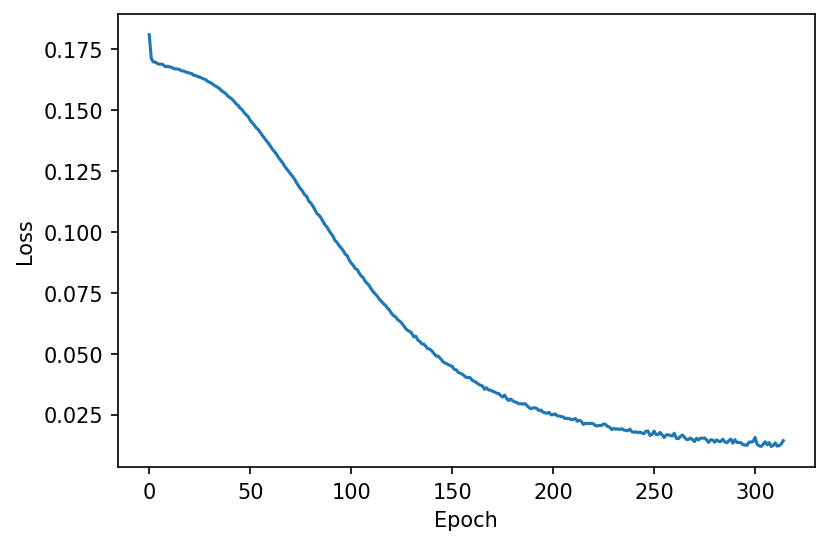

In [27]:
sns.lineplot(x = "Epoch",y = "Loss", data = dat)

After running an initial analysis on this model, these were our findings:
- The auc score for this model on test data was satisfactory but the auc score on the training data was exceptionally high. This is very convincing proof of overfitting.
- The accuracy score was also very high on the train which further pushes our argument that this model has been overfit on the training data.
- Hence this model is definitely not robust and may perform poorly on data that is foreign to the model.

### Grid Search Cross-Validation to arrive at the best model

We use Grid Search Cross Validation to help us arrive at the best possible neural network model for our use case. This is a brute force method which uses every combination of hyper parameters to get the best model.

In [28]:
mlp = MLPClassifier(random_state=123,max_iter=1000)

In [29]:
parameter_space = {
    'hidden_layer_sizes': [(1,), (2,), (3,), (4,), (5,), (6,), (7,), (1,1), (2,2), (3,3), (4,4), (5,5), (6,6), (7,7), (1,1,1), (2,2,2), (3,3,3), (4,4,4), (5,5,5), (6,6,6), (7,7,7)],
    'activation': ['tanh', 'relu','logistic'],
    'solver': ['sgd', 'adam','lbfgs'],
    'learning_rate': ['adaptive','constant'],
}

In [30]:
# Cross validation switch

cv = False

In [31]:
if cv:
    clf = GridSearchCV(mlp, parameter_space, n_jobs=-1, scoring='roc_auc', verbose=4)
    clf.fit(X_train, y_train.values.ravel())

### Neural Network Model 2

Our second model uses the hyper parameters suggested by the Grid Search algorithm to set the model. We will again train the model on the same data set as model 1.

In [33]:
# Training model using the parameters selected by CV above

clf_2 = MLPClassifier(random_state=123, activation='relu', solver='adam', max_iter=1000, hidden_layer_sizes = (3,3), learning_rate='adaptive').fit(X_train, y_train.values.ravel())

In [34]:
# Prediction probabilities on the test set
pred = clf_2.predict_proba(X_test)
probs = pd.Series([p[1] for p in pred])

# Prediction probabilities on the train set
pred_train = clf_2.predict_proba(X_train)
probs_train = pd.Series([p[1] for p in pred_train])

In [35]:
fpr, tpr, thresholds = metrics.roc_curve(y_test.res1_yes, pred[:,1])
print(f'Test data auc is {metrics.auc(fpr,tpr)}')

Test data auc is 0.7537063537135102


In [36]:
fpr, tpr, thresholds = metrics.roc_curve(y_train.res1_yes, pred_train[:,1])
print(f'Train data auc is {metrics.auc(fpr,tpr)}')

Train data auc is 0.7559930268922149


In [37]:
breakeven = 1.41/60

In [38]:
# Profit calculation on train set

pred_prof = pd.Series((probs/2)) 
pred_prof.name = 'predictions_model_2_test'

pred_prof_train = pd.Series((probs_train/2))
pred_prof_train.name = 'predictions_model_2_train'

df_test = df_test.join(pred_prof, how='inner')
df_train = df_train.join(pred_prof_train, how='inner')

In [39]:
df_test

,res1_yes,predictions_model_1_test,predictions_model_2_test
0,0,3.224312e-05,0.010613
1,0,2.501738e-08,0.047164
2,0,6.676777e-03,0.012809
3,0,8.324650e-09,0.017358
4,0,5.649750e-11,0.007661
...,...,...,...
22495,0,6.936462e-09,0.010933
22496,0,6.731326e-11,0.007028
22497,0,1.504177e-05,0.046599
22498,1,1.484497e-04,0.072720


In [40]:
p = profit_max(df_test,'res1_yes',1,'predictions_model_2_test',1.41,60)

print(f'The profit for {clf_2} on the test data is ${p}')

The profit for MLPClassifier(hidden_layer_sizes=(3, 3), learning_rate='adaptive',
              max_iter=1000, random_state=123) on the test data is $35510.67


In [41]:
# Confusion Matrix

TP, FP, TN, FN, contact = confusion(df_test,'res1_yes',1,'predictions_model_2_test',1.41,60)

print(f'TP: {TP}')
print(f'TN: {TN}')
print(f'FP: {FP}')
print(f'FN: {FN}')

TP: 759
TN: 15043
FP: 6354
FN: 344


In [42]:
a = ((probs/2) > breakeven).astype(int)
a_train = ((probs_train/2) > breakeven).astype(int)

In [43]:
acc = np.mean(a == y_test['res1_yes'])
print(f'Test data accuracy {acc}')

Test data accuracy 0.7023111111111111


In [44]:
acc_train = np.mean(a_train == y_train['res1_yes'])
print(f'Train data accuracy {acc_train}')

Train data accuracy 0.6997333333333333


In [45]:
print(f'Minimum Loss is {min(clf_2.loss_curve_)}')

Minimum Loss is 0.16945831813773668


In [46]:
l = clf_2.loss_curve_
x = list(range(clf_2.n_iter_))

In [47]:
df = pd.DataFrame({'Loss':l,'Epoch':x})

<AxesSubplot:xlabel='Epoch', ylabel='Loss'>

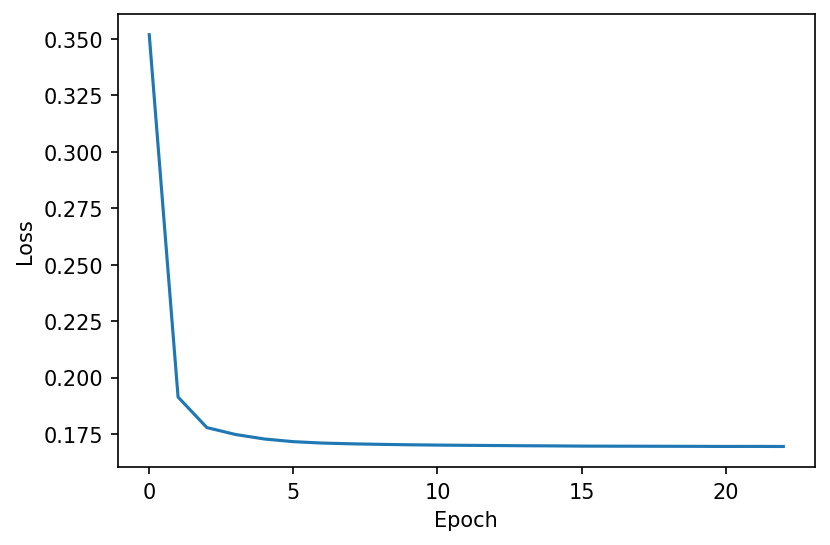

In [48]:
sns.lineplot(x = "Epoch",y = "Loss", data = df)

After running an initial analysis on this model, these were our findings:
- We can see that the minimum loss of model 1 is lower than that of model 2. This may indicate that model 1 is better.
- The auc scores of the model on both training and test data is great. It falls in the satisfactory range of 0.6-0.8 . The auc score on the training data is not exceptionally high indicating that the model is not suffering from over-fitting and is hence robust.

### Comparing the two Neural Network Models

<AxesSubplot:xlabel='Proportion of customers', ylabel='Profit'>

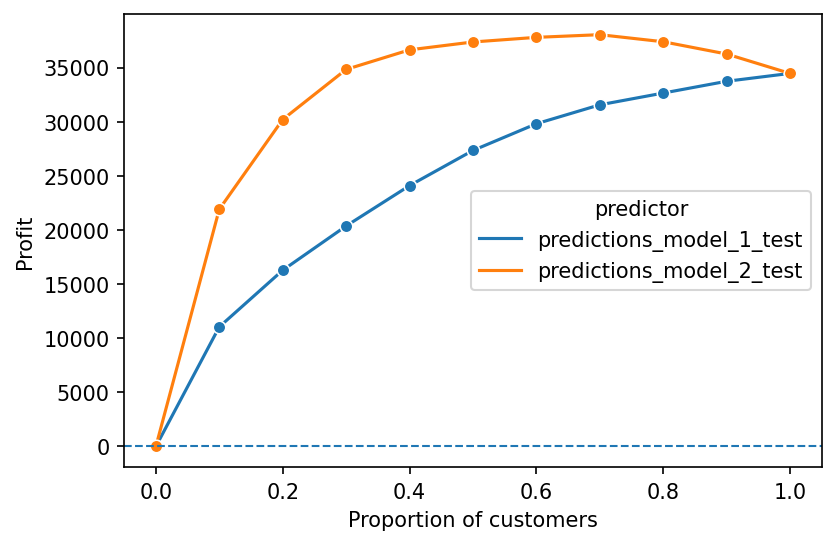

In [49]:
# Profit plot

profit_plot(df=df_test,rvar='res1_yes',lev=1,pred=['predictions_model_1_test','predictions_model_2_test'],cost=1.41,margin=60)

<AxesSubplot:xlabel='Proportion of customers', ylabel='Cumulative gains'>

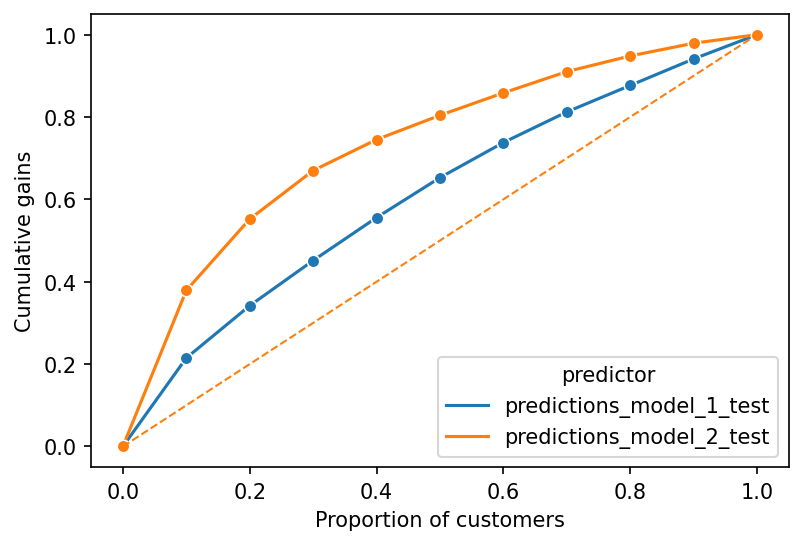

In [50]:
# Gains plot

gains_plot(df=df_test,rvar='res1_yes',lev=1,pred=['predictions_model_1_test','predictions_model_2_test'])

<AxesSubplot:xlabel='Proportion of customers', ylabel='Cumulative lift'>

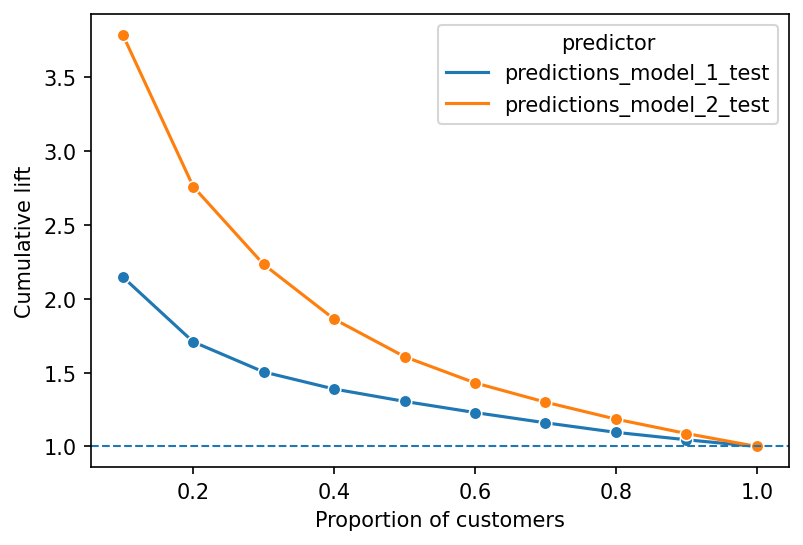

In [51]:
# Lift plot

lift_plot(df=df_test,rvar='res1_yes',lev=1,pred=['predictions_model_1_test','predictions_model_2_test'])

<AxesSubplot:xlabel='Proportion of customers', ylabel='Return on Marketing Expenditures (ROME)'>

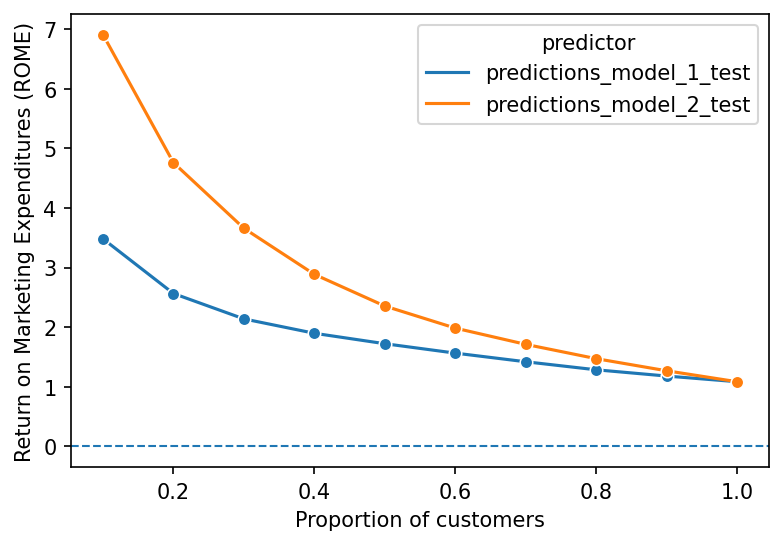

In [52]:
# ROME plot

ROME_plot(df=df_test,rvar='res1_yes',lev=1,pred=['predictions_model_1_test','predictions_model_2_test'], cost=1.41,margin=60)

- There is significant amount of daylight between model 1 and model 2 in both the profit and the gains plots. Model 2 sits well above model 1 and hence it is clearly the superior model.
- The lift and ROME plots also tell a similar story. Model 2 performs significantly better on both fronts, sitting well above model 1.
- The profit that we expect from the IDs of customers targeted by model 2 is much higher as compared to that of model 1.

##### Hence model 2 will our preferred choice for a neural network.